In [1]:
import pathlib

from Bio.PDB import PDBParser
from Bio.Data.IUPACData import protein_letters_3to1

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker
from matplotlib.patches import Circle, Rectangle

import numpy as np
import pandas as pd

In [2]:
# Truetype fonts for better handling in Designer/Illustrator
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
# mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
# define color pallete (cvd-friendly)
blue = '#005AB5'
red = '#DC3220'
gray = '#D0D0D0'

In [4]:
print(mpl.__version__)
print(pd.__version__)

3.3.4
1.2.4


In [5]:
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = cm.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki, key in enumerate(('red','green','blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1)]
    # Return colormap object.
    return mpl.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [6]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [7]:
# Scientific to Common
namedict1 = {
    'anas_platyrhynchos':'Duck',
    'anser_cygnoides_domesticus':'White goose',
    'bos_taurus':'Cow',
    'callithrix_jacchus':'Marmoset',
    'canis_lupus_familiaris':'Dog',
    'chlorocebus_aethiops':'Green monkey',
    'coturnix_japonica':'Quail',
    'cricetulus_griseus':'Chinese hamster',
    'felis_catus':'Cat',
    'gallus_gallus':'Chick',
    'gorilla_gorilla':'Gorilla',
    'homo_sapiens':'Human',
    'macaca_fascicularis':'Machin',
    'macaca_mulatta':'Rhesus monkey',
    'mesocricetus_auratus':'Syrian hamster',
    'microtus_ochrogaster':'Field mouse',
    'mus_musculus':'Rat',
    'mustela_putorius':'Ferret',
    'neovison_vison':'Mink',
    'odocoileus_virginianus':'White-tailed deer',
    'panthera_leo':'Lion',
    'panthera_tigris':'Tiger',
    'papio_anubis':'Baboons',
    'peromyscus_maniculatus':'Caclus mouse', 'phodopus_roborovskii':'Desert hamster','procyon_lotor':'Raccoon','rousettus_aegyptiacus':'Egyotian fruit bat', 'sus_scrofa':'Pig'

}

# Lower case and underscore
namedict = {
    '_'.join(k.lower().split()[:2]): v
    for k, v in namedict1.items()
}

In [8]:
# Sets of sars-cov-2 positive/negative species
positive = [
    'bos_taurus',
    'callithrix_jacchus',
    'canis_lupus_familiaris',
    'chlorocebus_aethiops',
    'felis_catus',
    'gorilla_gorilla',
    'homo_sapiens',
    'macaca_fascicularis',
    'macaca_mulatta',
    'microtus_ochrogaster',
    'mustela_putorius',
    'neovison_vison',
    'odocoileus_virginianus',
    'panthera_leo',
    'panthera_tigris',
    'papio_anubis'
]

positive = list(map(namedict1.get, positive))

negative = [
    'mesocricetus_auratus'
    'anser_cygnoides_domesticus'
    'cricetulus_griseus'
    'coturnix_japonica'
    'gallus_gallus'
    'mus_musculus'
    'procyon_lotor'
    'sus_scrofa'
]

negative = list(map(namedict1.get, negative))

In [10]:
rootdir = pathlib.Path('.').resolve(strict=True)
datadir = rootdir.parent / 'refinement' / 'Omicron'

In [11]:
# Read in PDB files for each species
parser = PDBParser(QUIET=1)
pdbs = list(datadir.rglob('*1.pdb'))
pdbdict = {}
for pdb in pdbs:
#     print(pdb)
    chaindict = {}
    s = parser.get_structure('x', str(pdb))
    for chain in s.get_chains():
        chaindict[chain.id] = {}
        for res in chain:
            resi = res.id[1]
            resn = protein_letters_3to1.get(res.resname.capitalize())
            if resn is None:
                continue
            chaindict[chain.id][resi] = resn
    species = namedict.get(pdb.parent.name)
    if species is None:
        raise Exception(species)
    pdbdict[species]= chaindict

In [12]:
df = pd.read_excel(datadir / 'omicron.xlsx', index_col='species')
df.index = map(namedict.get, df.index)
df.head(2)

,B19,B20,B21,B22,B23,B24,B25,B26,B27,B28,...,B330,B351,B352,B353,B354,B355,B357,B386,B387,B393
Duck,-22.565014,NaN,-26.579041,NaN,-29.700642,-34.31082,-25.077054,-31.322469,-31.824420,-37.287570,...,-29.297117,-38.433048,-19.742040,-38.006146,-22.198043,-49.494708,-51.706455,-25.420249,-20.245690,-55.163647
White goose,-19.316627,NaN,-25.717461,NaN,-21.556298,-37.95647,-26.107487,-27.398528,-31.258821,-36.316845,...,-31.869070,-36.697232,-18.287251,-31.653092,-31.278615,-47.131569,-53.010746,-25.261505,-18.982307,-52.721895


In [13]:
# Remove all 0.0 columns
df = df[df != 0.0].dropna(axis=1, how='all')

In [14]:
# Load seq_id to sort by HS
df2 = pd.read_csv(datadir.parent / '1111.dat', index_col='species')
df2.index = map(namedict1.get, df2.index)
df2.head(2)

,HS
Duck,-131.03
White goose,-140.11


In [15]:
df['HS'] = df2['HS']
df.sort_values(by='HS', inplace=True)
df.drop(columns=['HS'], inplace=True)
df.head(2)

,B19,B20,B21,B22,B23,B24,B25,B26,B27,B28,...,B330,B351,B352,B353,B354,B355,B357,B386,B387,B393
Mink,-14.078525,-21.004719,-21.679643,NaN,-34.379882,-33.732591,-26.428329,-51.460984,-29.467370,-40.734695,...,-28.324988,-38.116462,-19.029157,-33.094840,-23.009664,-46.952462,-49.706086,-22.600581,-17.505875,-53.10203
Ferret,-13.860202,-21.561697,-25.396900,NaN,-34.932107,-35.638135,-26.973387,-48.542287,-30.408299,-41.627695,...,-31.139182,-38.289214,-18.473303,-35.298529,-34.921921,-45.417760,-54.126469,-24.007190,-24.682936,-54.30852


In [16]:
# Pick columns for each protein based on chain ID
ace2_cols = [c for c in df.columns if 'B' in c]
vrbd_cols = [c for c in df.columns if 'E' in c]

ace2 = df[ace2_cols]
vrbd = df[vrbd_cols]

In [17]:
# Make dataframes with residue names for annotation
ace2_annot = ace2.copy(deep=True)
for row in ace2_annot.index:
    for col in ace2_annot.columns:
        chain = col[0]
        resid = int(col[1:])
        try:
            aakey = pdbdict[row][chain][resid]
        except KeyError:
            aakey = 'X'
        ace2_annot.loc[row, col] = aakey
# ace2_annot.head(2)

vrbd_annot = vrbd.copy(deep=True)
for row in vrbd_annot.index:
    for col in vrbd_annot.columns:
        chain = col[0]
        resid = int(col[1:])
        try:
            aakey = pdbdict[row][chain][resid]
        except KeyError:
            aakey = 'X'
        vrbd_annot.loc[row, col] = aakey
vrbd_annot.head(2)

""
Mink
Ferret


In [18]:
df.columns

Index(['B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28',
       'B29', 'B30', 'B31', 'B32', 'B33', 'B34', 'B35', 'B36', 'B37', 'B38',
       'B39', 'B40', 'B41', 'B42', 'B43', 'B45', 'B48', 'B49', 'B61', 'B68',
       'B72', 'B75', 'B76', 'B78', 'B79', 'B80', 'B81', 'B82', 'B83', 'B323',
       'B324', 'B325', 'B326', 'B327', 'B329', 'B330', 'B351', 'B352', 'B353',
       'B354', 'B355', 'B357', 'B386', 'B387', 'B393'],
      dtype='object')

## Figure

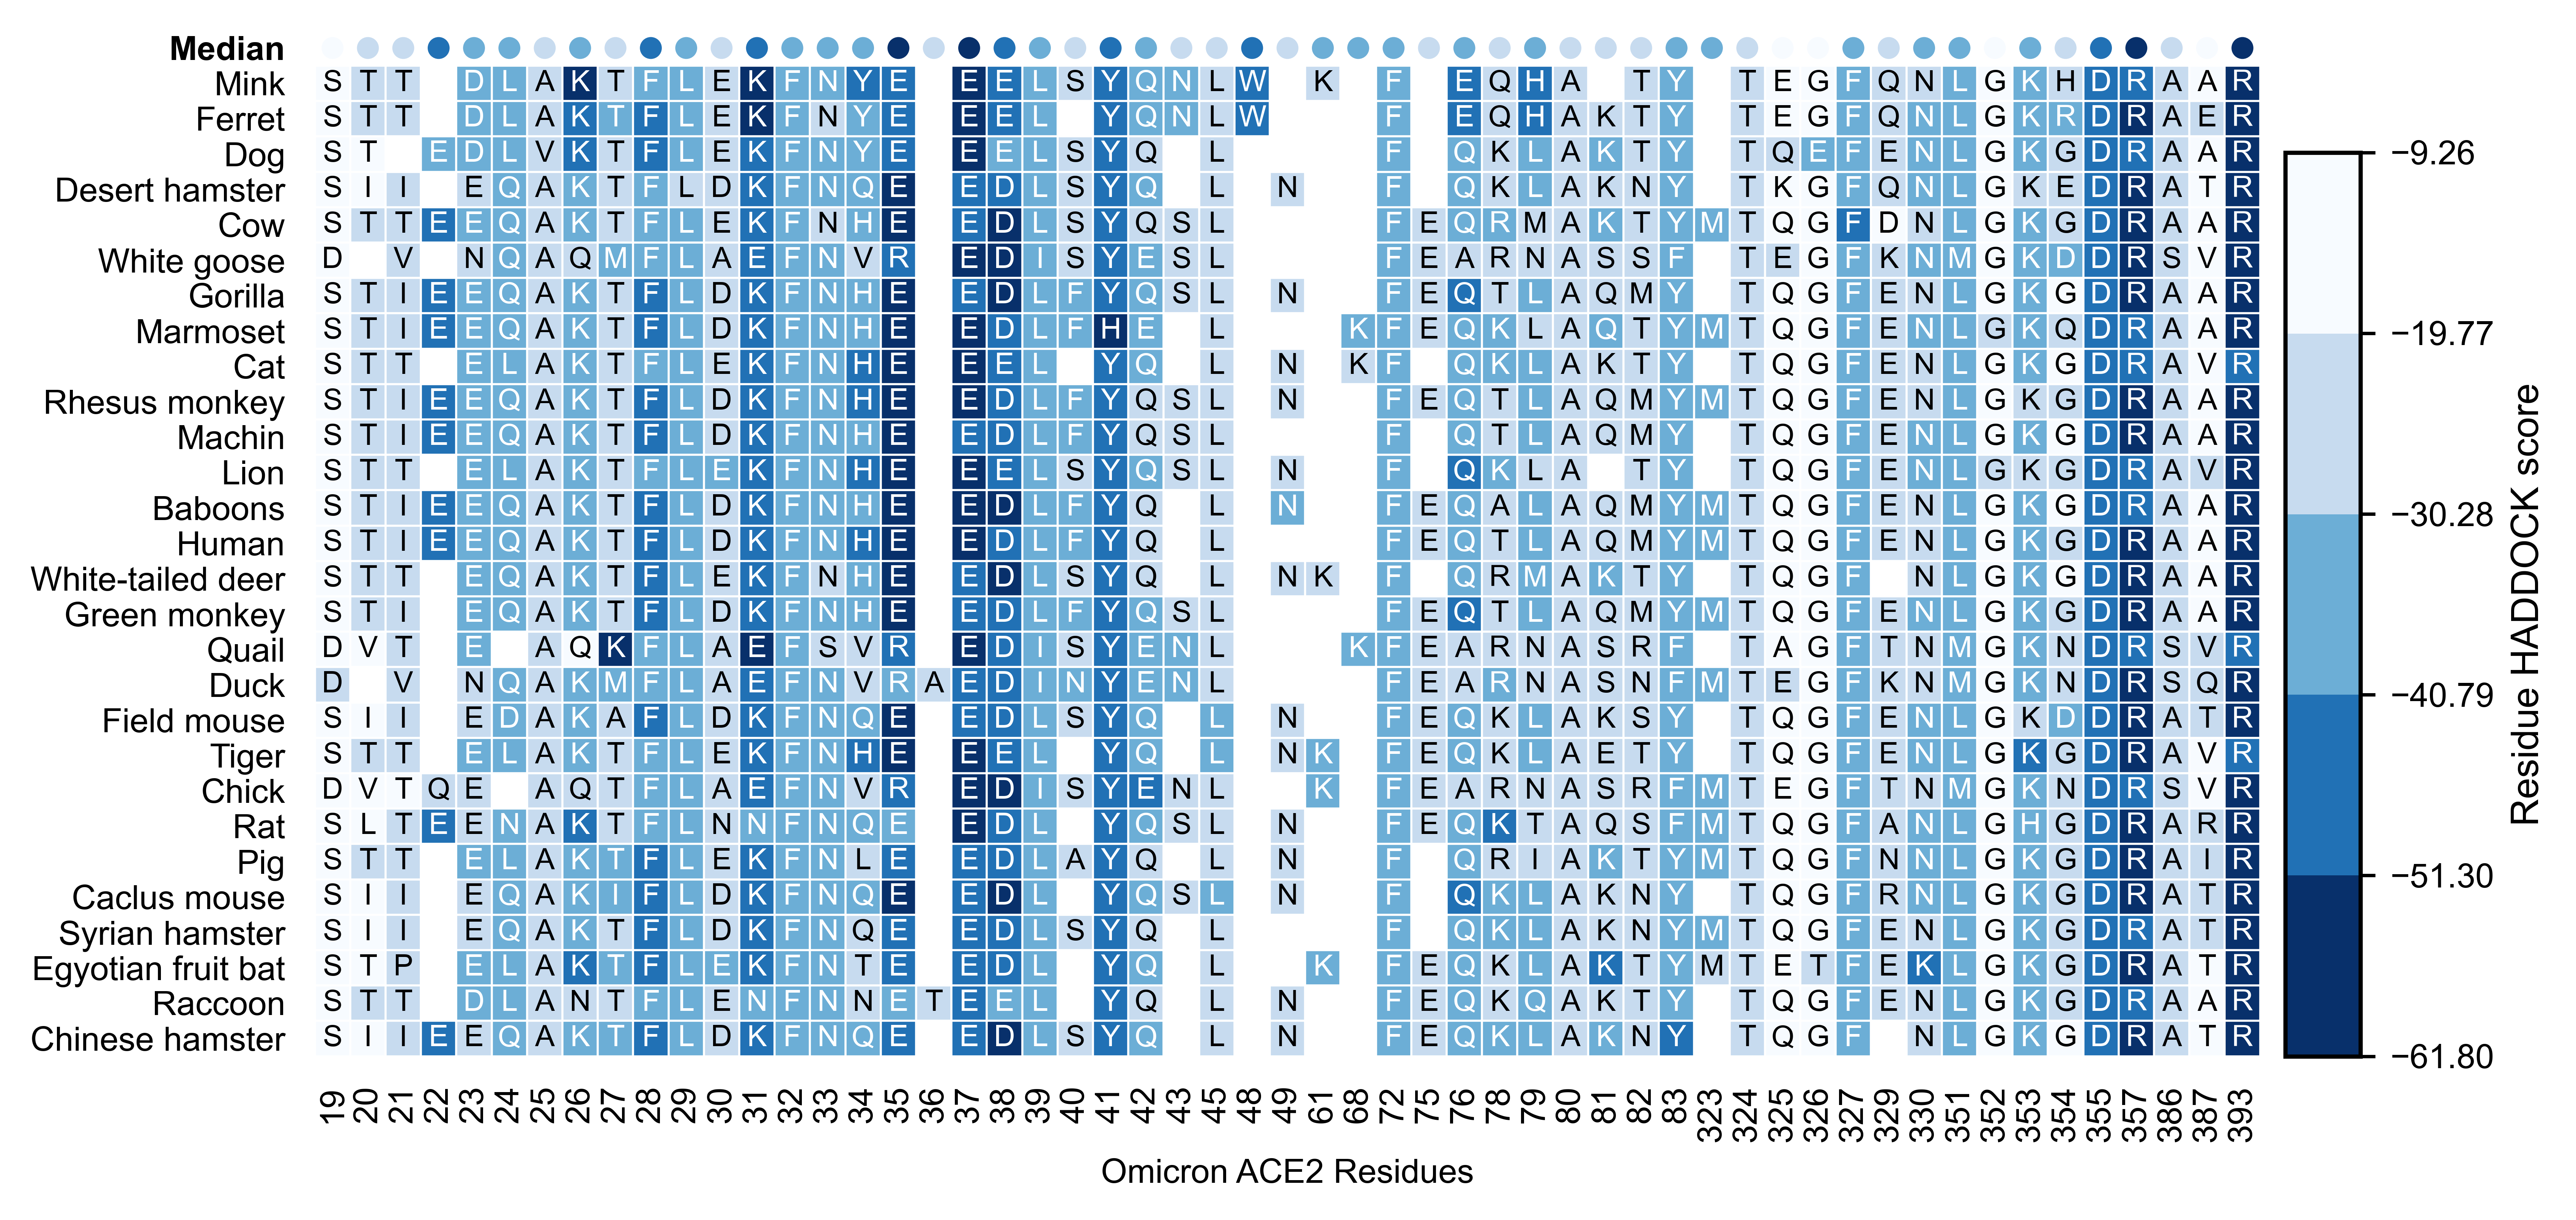

In [19]:
fig, ax1 = plt.subplots(
    nrows=1, ncols=1,
    figsize=cm2inch(21, 14),  # w,h
    dpi=800  # for viewing here on notebook
)

# Calculate average row and add it to df
mask = ace2[ace2 == 0.0].astype(bool)
ave_data = ace2[mask].median().to_frame().T
ave_data.rename({0: 'Median'}, inplace=True)

# make copy with blank values
ave_data_blank = ave_data.copy(deep=True)
ave_data_blank.loc['Median'] = np.nan

# Merge
data = pd.concat([ave_data_blank, ace2[mask]])

# Create discrete colormap
discretized_cmap = cmap_discretize('Blues_r', 5)

# Per species heatmap
hm = ax1.imshow(
    data.values,
    cmap=discretized_cmap,
    interpolation=None
)

# Remove spines and make white grid
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ax1.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", bottom=False, left=False)

# Set axes labels
ax1.set_xticks(np.arange(data.shape[1]))
ax1.set_yticks(np.arange(data.shape[0]))

# Turn first row to circles for distinction
nr, nc = ave_data.shape
for col in range(nc):
    v = ave_data.iloc[0, col]
    c = hm.cmap(hm.norm(v))

    circ = Circle(
        (col, 0),
        radius=0.25,
        color=c
    )
    ax1.add_patch(circ)

# Replace imshow with individual squares
# for editability in illustrator/etc
nr, nc = data.shape
for x in range(nc):
    for y in range(1, nr):
        v = data.iloc[y, x]

        if v == 0.0:
            continue

        c = hm.cmap(hm.norm(v))

        sq = Rectangle(
            (x - .5, y - .5),
            width=1,
            height=1,
            color=c,
            linewidth=0
        )

        ax1.add_patch(sq)
    
# Add amino acid labels
# Pick font color based on luminance of background
# from seaborn source
def get_font_color(data, px, py):

    v = data.iloc[px, py]
    color = hm.cmap(hm.norm(v))
    
    rgb = mpl.colors.colorConverter.to_rgba_array(color)[:, :3]
    rgb = np.where(rgb <= .03928, rgb / 12.92, ((rgb + .055) / 1.055) ** 2.4)
    lum = rgb.dot([.2126, .7152, .0722])
    return "k" if lum > .408 else "w"

    
nx, ny = ace2.shape
for i in range(nx):
    for j in range(ny):
        if ace2.iloc[i, j] == 0.0:
            continue
        text = ax1.text(
            j, i + 1, ace2_annot[mask].iloc[i, j],
            ha="center", va="center",
            color=get_font_color(data, i + 1, j),
            size=7
        )
    
# Handle labels
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')

xlabels = []
for c in data.columns:
    resi = c[1:]  # clip chain name
    if int(resi) > 1000:  # replace first digit with X
        resi = 'x' + resi[1:]
    xlabels.append(resi)

ax1.set_xticklabels(
    xlabels,
    fontsize=8,
    rotation=90
)

ax1.set_yticklabels(
    data.index,
    fontsize=8
)

ax1.set_xlabel('Omicron ACE2 Residues', size=8)

for l in ax1.yaxis.get_ticklabels():  # bold average
    l.set_fontweight('bold')
    break

# Color ylabels
# for l in ax1.yaxis.get_ticklabels():
#     l_text = l.get_text()
#     if l_text in positive_set:
#         l.set_c(blue)
#     elif l_text in negative_set:
#         l.set_c(red)
#     else:
#         l.set_c('k')


# Create colorbar
fig.canvas.draw()  # draw first to get positions
ax_pos = ax1.get_position()
cbax = fig.add_axes([
    ax_pos.xmax + 0.01,  # xmax + pad
    ax_pos.ymin,
    0.03,
    0.54
])

ydata = data.values[~np.isnan(data.values)].ravel()
datamin, datamax = ydata.min(), ydata.max()
datarange = datamax - datamin
datastep = datarange / 5
cbticks = [datamax - (i*datastep) for i in range(6)]

cbar = fig.colorbar(
    hm,
    cax=cbax,
    orientation='vertical',
    pad=0,
    ticks=cbticks
)
cbar.ax.set_ylabel('Residue HADDOCK score', size=9)
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_fontsize(8)

cbar.outline.set_linewidth(1.0)

# Hide imshow data
data_copy = data.copy(deep=True)
for col in data_copy.columns:
    data_copy[col].values[:] = np.nan
hm.set_data(data_copy)

In [ ]:
fig.savefig('omicron-residues-scores.png', dpi=800 , bbox_inches="tight")